In [5]:
from astropy.table import Table

import numpy as np

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

# Data

In [3]:
#data_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt'
data_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_v5.txt'

data = Table.read(data_filename, format='ascii.commented_header')

In [4]:
kias_filename = '/Users/kellydouglass/Documents/Research/data/kias1033_5_MPAJHU_ZdustOS_HI100_NSAv012_CMDJan2020.txt'

kias = Table.read(kias_filename, format='ascii.commented_header')

In [6]:
################################################################################
# Calculate the velocity at R90
#-------------------------------------------------------------------------------
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

dist_to_galaxy_Mpc = c*data['NSA_redshift']/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

data['R90_kpc'] = dist_to_galaxy_kpc*np.tan(data['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

data['V90_kms'] = rot_fit_BB(data['R90_kpc'], 
                             [data['Vmax_map'], 
                              data['Rturn_map'], 
                              data['alpha_map']])
################################################################################


bad_boolean = np.logical_or.reduce([np.isnan(data['M90_map']), 
                                    np.isnan(data['M90_disk_map']), 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998, 
                                    data['V90_kms']/data['Vmax_map'] < 0.9, 
                                    (data['Tidal'] & (data['DL_merge'] > 0.97))])

good_galaxies = data[~bad_boolean]

'''
bad_boolean = np.logical_or.reduce([data['M90_map'] == -99, 
                                    data['M90_disk_map'] == -99, 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998])

good_galaxies = data[~bad_boolean]
'''
print(len(good_galaxies))

1951


In [7]:
good_galaxies[:10]

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,Hubble_type,Tidal,GZ_edge_on,GZ_bar,GZ_spiral,mangaid,DL_ttype,DL_s0,DL_edge_on,DL_bar_GZ2,DL_bar_N10,DL_merge,R90_kpc,V90_kms
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str6,int64,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64
8466,3704,1365,395,53062,271835,169.51344705905626,45.11302884764515,0.7605966925621033,38.829132080078125,0.10723754018545151,197521702912.0,-9.0,556.3518364096462,13.118034688446018,24.86932770334229,2.3940713635654394,30.91707350025701,711.2244069248968,1.504693687838659,5.4916272484783235,0.13302098092829132,57.779777593071636,719.3795558341147,138.28434946354537,2.3152653148416644,0.34190799281498013,679.599992107137,0.19382250308990479,0.00374262968525048,1009538499616.6031,47607149629.30096,675644982315.1558,47607149629.30096,333893517301.4474,2.023534292536643,0.14258183271740504,-22.550582885742188,5.7748020245614216,0.5573857339405546,4.4524855677404895,0.01905772437112725,13.420360045586433,3.15075413321062,-99.0,-99.0,1.0,0,2,7.729268375064253,14.444944398267909,169.89999802678426,1238769,-99.0,2.2696952521800995,0.3984819734345351,14.027650044796358,3.023534292536643,0.14258183271740504,2.000058917217074,781.0113415220086,852.3600886325648,-31.43738195467922,0.9191594634941147,0.9996160361859993,14.92701049920957,1.9016935015289356,90.83466065793536,6.646944003882518,25.925575994142413,0.3809794467255559,18.674050361874897,0.6673493853020757,583.2328253935871,34.152175648873666,2.4839515490849142,0.31532918333860444,3.6599846826451374,0.8402844742808679,12.220250755739624,11.288857167962382,2643.9946172860446,143.58157468583985,3.0807158316405787,0.11520078007864021,11.167253620298242,13.076544983597937,1.2732320010865508,13.470475196838379,53.76509128464788,12836786.035053207,nan,nan,nan,2,-2.0,Sa,1,0.09673986649898424,0.0360929634786334,0.0,1-256832,-2.5520172119140625,0.2188923954963684,0.022004038095474243,0.48675888776779175,0.02322487160563469,0.5364497900009155,20.995456918513632,580.1967832784323
8465,1901,1281,231,52753,247928,197.44581468983537,48.899591403437014,0.7684928178787231,18.52703857421875,0.028888285160064697,1

### Pull out those objects with HI observations

In [8]:
#HI_boolean = np.logical_or(good_galaxies['logHI'] == -99, good_galaxies['logHI'] == -999)
HI_boolean = np.logical_or(np.isnan(good_galaxies['logHI']), 
                           good_galaxies['logHI'] == -999)

goodHI_galaxies = good_galaxies[~HI_boolean]

print(len(goodHI_galaxies))

862


### Calculate mass ratios

In [9]:
good_galaxies['M90_Mdisk_ratio'] = 10**(good_galaxies['M90_map'] - good_galaxies['M90_disk_map'])
goodHI_galaxies['M90_Mdisk_ratio'] = 10**(goodHI_galaxies['M90_map'] - goodHI_galaxies['M90_disk_map'])

goodHI_galaxies['M90_MdiskHI_ratio'] = 10**goodHI_galaxies['M90_map']/(10**goodHI_galaxies['M90_disk_map'] + 10**goodHI_galaxies['logHI'])

goodHI_galaxies['M90_vis'] = np.log10(10**goodHI_galaxies['M90_disk_map'] + 10**goodHI_galaxies['logHI'])

### Separate by CMD classification

In [10]:
BC_boolean = good_galaxies['CMD_class'] == 1
GV_boolean = good_galaxies['CMD_class'] == 2
RS_boolean = good_galaxies['CMD_class'] == 3

BC = good_galaxies[BC_boolean]
GV = good_galaxies[GV_boolean]
RS = good_galaxies[RS_boolean]

print('Blue cloud:', len(BC), np.sum(BC['M90_Mdisk_ratio'] < 20))
print('Green valley:', len(GV), np.sum(GV['M90_Mdisk_ratio'] < 20))
print('Red sequence:', len(RS), np.sum(RS['M90_Mdisk_ratio'] < 20))

Blue cloud: 949 826
Green valley: 480 429
Red sequence: 341 294


In [11]:
BC_HI_boolean = goodHI_galaxies['CMD_class'] == 1
GV_HI_boolean = goodHI_galaxies['CMD_class'] == 2
RS_HI_boolean = goodHI_galaxies['CMD_class'] == 3

BC_HI = goodHI_galaxies[BC_HI_boolean]
GV_HI = goodHI_galaxies[GV_HI_boolean]
RS_HI = goodHI_galaxies[RS_HI_boolean]

print('Blue cloud:', len(BC_HI))
print('Green valley:', len(GV_HI))
print('Red sequence:', len(RS_HI))

Blue cloud: 539
Green valley: 151
Red sequence: 76


In [12]:
kias_BC_boolean = kias['CMD_class'] == 1
kias_GV_boolean = kias['CMD_class'] == 2
kias_RS_boolean = kias['CMD_class'] == 3

kias_BC = kias[kias_BC_boolean]
kias_GV = kias[kias_GV_boolean]
kias_RS = kias[kias_RS_boolean]

# Sample stats
## Median values

In [13]:
print('Blue cloud:', np.median(BC['M90_Mdisk_ratio']))
print('Green valley:', np.median(GV['M90_Mdisk_ratio']))
print('Red sequence:', np.median(RS['M90_Mdisk_ratio']))

Blue cloud: 4.322300216598814
Green valley: 3.3761598274624607
Red sequence: 4.310660831586254


In [14]:
print('Blue cloud:', np.median(BC_HI['M90_MdiskHI_ratio']))
print('Green valley:', np.median(GV_HI['M90_MdiskHI_ratio']))
print('Red sequence:', np.median(RS_HI['M90_MdiskHI_ratio']))

Blue cloud: 2.724828773336118
Green valley: 2.513138767018931
Red sequence: 2.946882676939566


# Distribution over $R_\text{max}$ and $R_{90}$

<IPython.core.display.Javascript object>


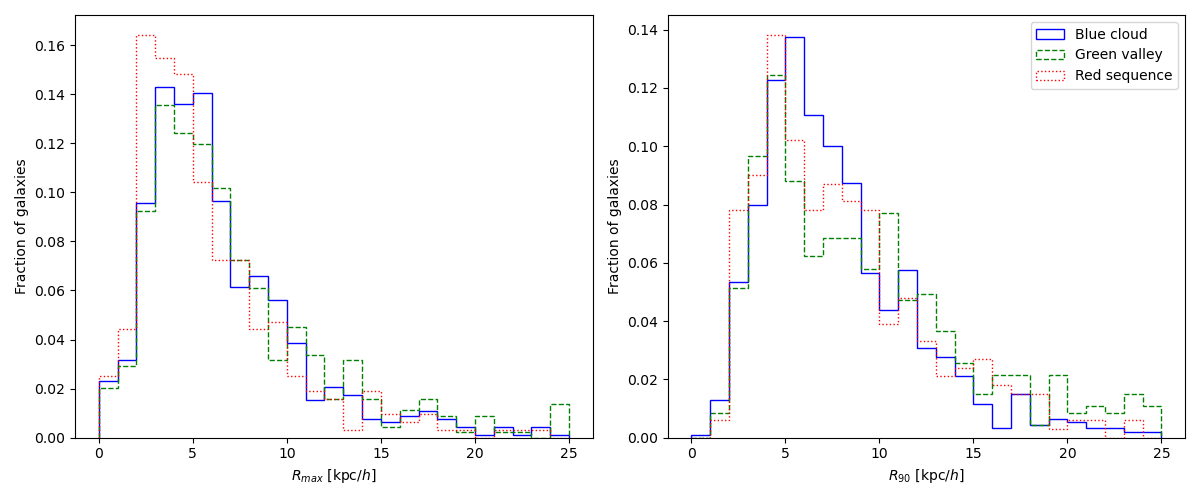

In [15]:
Rmax_bins = np.arange(0,26,1)

plt.figure(figsize=(12,5))



plt.subplot(121)

plt.hist(BC['Rmax'], bins=Rmax_bins, density=True, histtype='step', color='b', label='Blue cloud')
plt.hist(GV['Rmax'], bins=Rmax_bins, density=True, histtype='step', color='g', linestyle='--', label='Green valley')
plt.hist(RS['Rmax'], bins=Rmax_bins, density=True, histtype='step', color='r', linestyle=':', label='Red sequence')

plt.xlabel('$R_{max}$ [kpc/$h$]')
plt.ylabel('Fraction of galaxies')



plt.subplot(122)

plt.hist(BC['R90_kpc'], bins=Rmax_bins, density=True, histtype='step', color='b', label='Blue cloud')
plt.hist(GV['R90_kpc'], bins=Rmax_bins, density=True, histtype='step', color='g', linestyle='--', label='Green valley')
plt.hist(RS['R90_kpc'], bins=Rmax_bins, density=True, histtype='step', color='r', linestyle=':', label='Red sequence')

plt.xlabel('$R_{90}$ [kpc/$h$]')
plt.ylabel('Fraction of galaxies')

plt.legend()

plt.tight_layout();

# Sample rotation curves

In [16]:
radii_max = np.linspace(0,1,50)

<IPython.core.display.Javascript object>


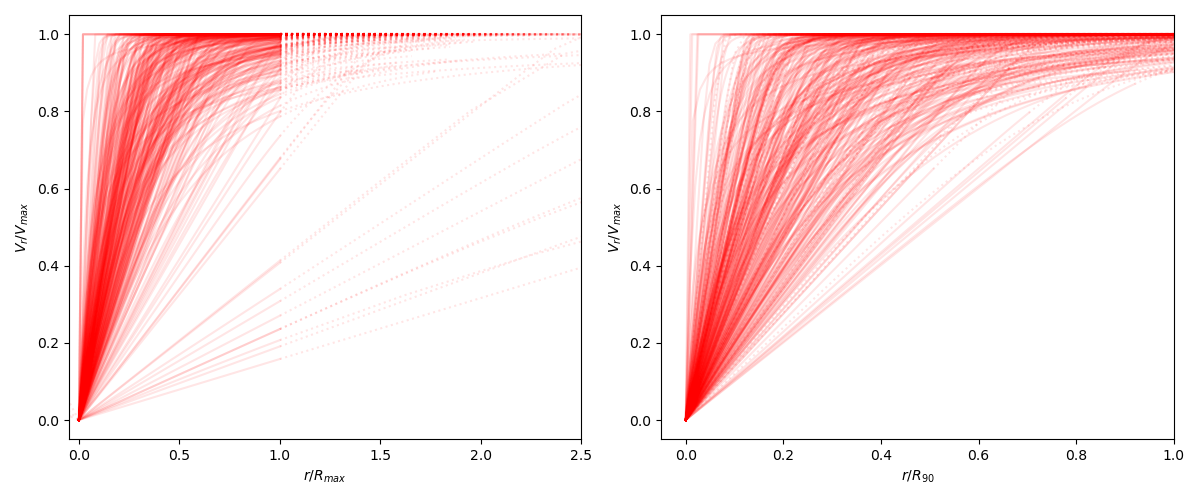

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:12: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:18: RuntimeWarning: invalid value encountered in power
  Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:12: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:18: RuntimeWarning: invalid value encountered in power
  Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:12: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rt

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:38: RuntimeWarning: invalid value encountered in power
  Vr_max = r_Rmax*R90/(Rturn**alpha + (r_Rmax*R90)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:44: RuntimeWarning: invalid value encountered in power
  Vr_90 = r_R90*R90/(Rturn**alpha + (r_R90*R90)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:38: RuntimeWarning: invalid value encountered in power
  Vr_max = r_Rmax*R90/(Rturn**alpha + (r_Rmax*R90)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:44: RuntimeWarning: invalid value encountered in power
  Vr_90 = r_R90*R90/(Rturn**alpha + (r_R90*R90)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/660546664.py:38: RuntimeWarning: invalid value encountered in power
  Vr_max = r_Rmax*R90/(Rturn**alpha + (r_Rmax*R90)**alpha)**(

In [17]:
plt.figure(figsize=(12,5))


plt.subplot(121)

for i in range(len(RS)):
    alpha = RS['alpha_map'][i]
    Rturn = RS['Rturn_map'][i]
    Rmax = RS['Rmax'][i]
    R90 = RS['R90_kpc'][i]
    
    Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
    
    plt.plot(radii_max, Vr_max, 'r', alpha=0.1)
    
    if R90 > Rmax:
        radii_90 = np.linspace(1,R90/Rmax,50)
        Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
        plt.plot(radii_90, Vr_90, 'r:', alpha=0.1)

plt.xlim([-0.05, 2.5])

plt.xlabel('$r/R_{max}$')
plt.ylabel('$V_r/V_{max}$')



plt.subplot(122)

for i in range(len(RS)):
    alpha = RS['alpha_map'][i]
    Rturn = RS['Rturn_map'][i]
    Rmax = RS['Rmax'][i]
    R90 = RS['R90_kpc'][i]
    
    r_Rmax = np.linspace(0,Rmax/R90,50)
    
    Vr_max = r_Rmax*R90/(Rturn**alpha + (r_Rmax*R90)**alpha)**(1/alpha)
    
    plt.plot(r_Rmax, Vr_max, 'r', alpha=0.1)
    
    if R90 > Rmax:
        r_R90 = np.linspace(Rmax/R90,1,50)
        Vr_90 = r_R90*R90/(Rturn**alpha + (r_R90*R90)**alpha)**(1/alpha)
        plt.plot(r_R90, Vr_90, 'r:', alpha=0.1)


plt.xlim([-0.05, 1])

plt.xlabel('$r/R_{90}$')
plt.ylabel('$V_r/V_{max}$')

plt.tight_layout();

<IPython.core.display.Javascript object>


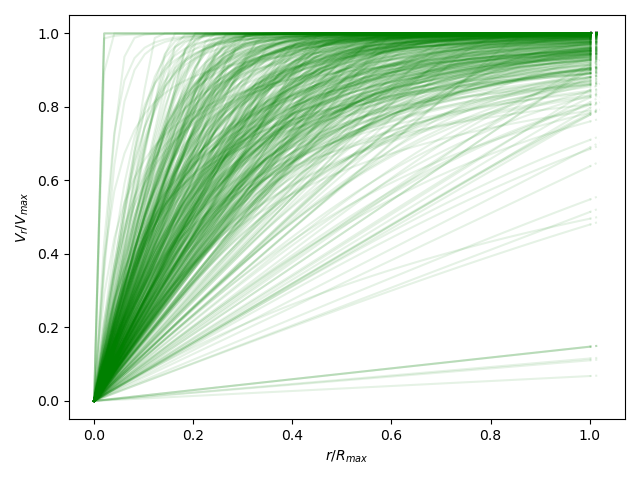

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/1078765292.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/1078765292.py:9: RuntimeWarning: invalid value encountered in power
  Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/1078765292.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/1078765292.py:9: RuntimeWarning: invalid value encountered in power
  Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/1078765292.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rt

In [18]:
plt.figure()

for i in range(len(GV)):
    alpha = GV['alpha_map'][i]
    Rturn = GV['Rturn_map'][i]
    Rmax = GV['Rmax'][i]
    
    Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
    Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
    
    plt.plot(radii_max, Vr_max, 'g', alpha=0.1)
    plt.plot(radii_90, Vr_90, 'g:', alpha=0.1)
    
plt.xlabel('$r/R_{max}$')
plt.ylabel('$V_r/V_{max}$')

plt.tight_layout();

<IPython.core.display.Javascript object>


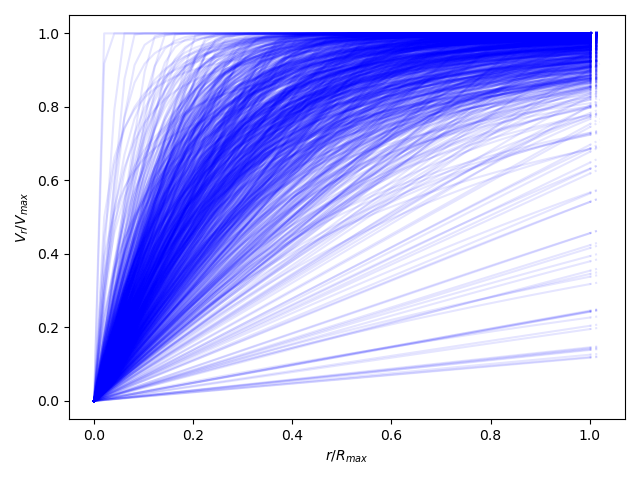

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:9: RuntimeWarning: invalid value encountered in power
  Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:9: RuntimeWarning: invalid value encountered in power
  Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rt

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:9: RuntimeWarning: invalid value encountered in power
  Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:9: RuntimeWarning: invalid value encountered in power
  Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_15372/3367545200.py:8: RuntimeWarning: invalid value encountered in power
  Vr_max = radii_max*Rmax/(Rt

In [19]:
plt.figure()

for i in range(len(BC)):
    alpha = BC['alpha_map'][i]
    Rturn = BC['Rturn_map'][i]
    Rmax = BC['Rmax'][i]
    
    Vr_max = radii_max*Rmax/(Rturn**alpha + (radii_max*Rmax)**alpha)**(1/alpha)
    Vr_90 = radii_90*Rmax/(Rturn**alpha + (radii_90*Rmax)**alpha)**(1/alpha)
    
    plt.plot(radii_max, Vr_max, 'b', alpha=0.1)
    plt.plot(radii_90, Vr_90, 'b:', alpha=0.1)
    
plt.xlabel('$r/R_{max}$')
plt.ylabel('$V_r/V_{max}$')

plt.tight_layout();

# Relationship between $M_*$ and $M_\text{tot}$

In [41]:
def bin_median(data, bin_quantity, bins, median_quantity):
    '''
    Calculate the median value of the quantity median_quantity when the objects in 
    data are binned by bin_quanitity.
    
    
    PARAMETERS
    ==========
    
    data : astropy table
        Galaxy data
        
    bin_quantity : string
        Name of column in data by which to bin the data
        
    bins : ndarray of shape (n,)
        Array of bin edges
        
    median_quantity : string
        Name of column in data for which to calculate the median once the data is 
        binned
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,)
        Median values of median_quantity for each bin of bin_quantity
        
    binned_err : ndarray of shape (n,)
        Statistical uncertainty in each bin (1/sqrt(N), where N is the number of 
        objects in the bin)
    '''
    
    if bin_quantity in ['Mstar', 'NSA_Mstar', 'Mstar_NSA']:
        bin_indices = np.digitize(np.log10(data[bin_quantity]), bins)
    else:
        bin_indices = np.digitize(data[bin_quantity], bins)
    
    n_bins = len(bins)
    
    binned_median = np.zeros(n_bins)
    binned_err = np.zeros(n_bins)
    
    for i in range(n_bins):
        # Find galaxies in this bin
        gal_in_bin = bin_indices == i
        
        # Calculate median of galaxies in bin
        if median_quantity in ['Mstar', 'NSA_Mstar', 'Mtot', 'Mstar_NSA']:
            binned_median[i] = np.log10(np.nanmedian(data[median_quantity][gal_in_bin]))
        elif median_quantity in ['M90_map', 'logHI']:
            binned_median[i] = np.log10(np.nanmedian(10**data[median_quantity][gal_in_bin]))
        else:
            binned_median[i] = np.nanmedian(data[median_quantity][gal_in_bin])
        
        # Calculate statistical uncertainty in bin
        binned_err[i] = np.sqrt(sum(gal_in_bin))
        
    return binned_median, binned_err

In [42]:
Mdisk_bins = np.linspace(9,12,9)
Mdisk_bin_width = Mdisk_bins[1] - Mdisk_bins[0]

BC_M90_medians, BC_M90_errs = bin_median(BC, 'M90_disk_map', Mdisk_bins, 'M90_map')
GV_M90_medians, GV_M90_errs = bin_median(GV, 'M90_disk_map', Mdisk_bins, 'M90_map')
RS_M90_medians, RS_M90_errs = bin_median(RS, 'M90_disk_map', Mdisk_bins, 'M90_map')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<IPython.core.display.Javascript object>


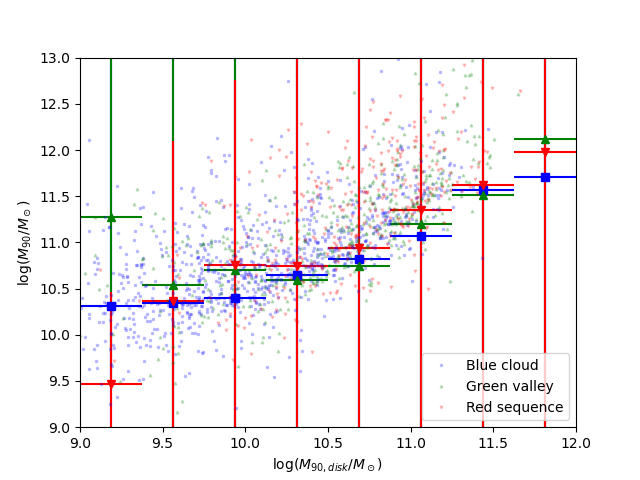

In [43]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.plot(BC['M90_disk_map'], BC['M90_map'], 'bs', markersize=2, alpha=0.2, label='Blue cloud')
plt.plot(GV['M90_disk_map'], GV['M90_map'], 'g^', markersize=2, alpha=0.2, label='Green valley')
plt.plot(RS['M90_disk_map'], RS['M90_map'], 'rv', markersize=2, alpha=0.2, label='Red sequence')

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, BC_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=BC_M90_errs, 
             c='b', fmt='s')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, GV_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=GV_M90_errs, 
             c='g', fmt='^')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, RS_M90_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=RS_M90_errs, 
             c='r', fmt='v')

plt.xlabel('log($M_{90, disk}/M_\odot$)')
plt.ylabel('log($M_{90}/M_\odot$)')

plt.xlim([9,12])
plt.ylim([9,13])

plt.legend();
################################################################################

# Relationship between $M_*$ and $M_{HI}$

In [44]:
BC_HI_medians, BC_HI_errs = bin_median(BC_HI, 'M90_disk_map', Mdisk_bins, 'logHI')
GV_HI_medians, GV_HI_errs = bin_median(GV_HI, 'M90_disk_map', Mdisk_bins, 'logHI')
RS_HI_medians, RS_HI_errs = bin_median(RS_HI, 'M90_disk_map', Mdisk_bins, 'logHI')

kias_BC_NSA_HI_medians, kias_BC_NSA_HI_errs = bin_median(kias_BC, 'Mstar_NSA', Mdisk_bins, 'HImass')
kias_GV_NSA_HI_medians, kias_GV_NSA_HI_errs = bin_median(kias_GV, 'Mstar_NSA', Mdisk_bins, 'HImass')
kias_RS_NSA_HI_medians, kias_RS_NSA_HI_errs = bin_median(kias_RS, 'Mstar_NSA', Mdisk_bins, 'HImass')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


<IPython.core.display.Javascript object>


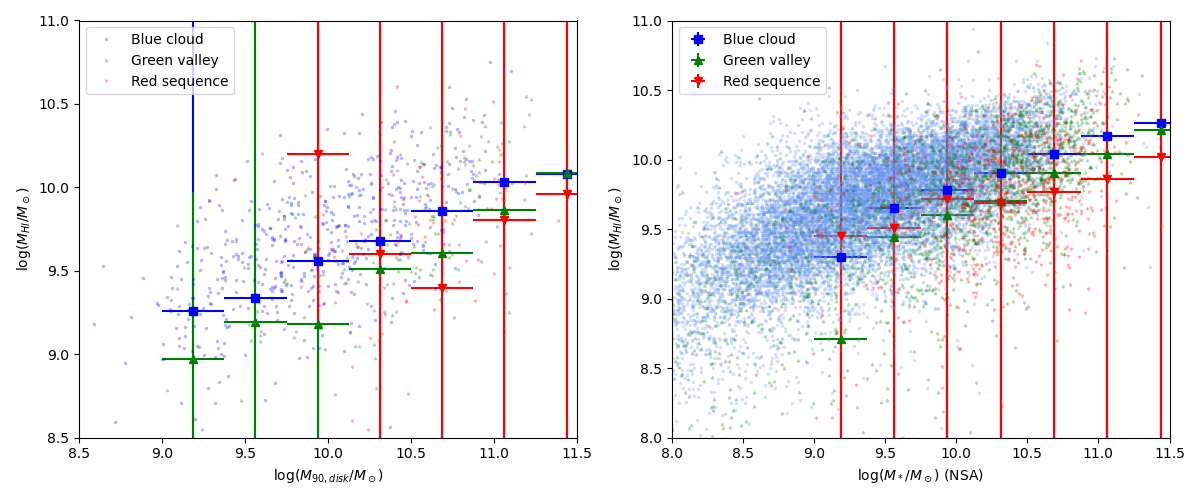

In [45]:
plt.figure(figsize=(12,5))

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.subplot(121)
plt.plot(BC_HI['M90_disk_map'], BC_HI['logHI'], 'bs', markersize=2, 
         alpha=0.2, label='Blue cloud')
plt.plot(GV_HI['M90_disk_map'], GV_HI['logHI'], 'g^', markersize=2, 
         alpha=0.2, label='Green valley')
plt.plot(RS_HI['M90_disk_map'], RS_HI['logHI'], 'rv', markersize=2, 
         alpha=0.2, label='Red sequence')

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, BC_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=BC_HI_errs, 
             c='b', fmt='s')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, GV_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=GV_HI_errs, 
             c='g', fmt='^')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, RS_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=RS_HI_errs, 
             c='r', fmt='v')

plt.xlabel('log($M_{90, disk}/M_\odot$)')
plt.ylabel('log($M_{HI}/M_\odot$)')

plt.xlim([8.5,11.5])
plt.ylim([8.5,11])

plt.legend()
################################################################################


################################################################################
# SDSS DR7
#-------------------------------------------------------------------------------
plt.subplot(122)
plt.plot(np.log10(kias_BC['Mstar_NSA']), kias_BC['HImass'], 's', 
         color='CornflowerBlue', markersize=2, alpha=0.2)
plt.plot(np.log10(kias_GV['Mstar_NSA']), kias_GV['HImass'], 'g^', markersize=2, 
         alpha=0.2)
plt.plot(np.log10(kias_RS['Mstar_NSA']), kias_RS['HImass'], 'rv', markersize=2, 
         alpha=0.2)

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_BC_NSA_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=kias_BC_NSA_HI_errs, 
             c='b', fmt='s', label='Blue cloud')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_GV_NSA_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=kias_GV_NSA_HI_errs, 
             c='g', fmt='^', label='Green valley')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, kias_RS_NSA_HI_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=kias_RS_NSA_HI_errs, 
             c='r', fmt='v', label='Red sequence')

plt.xlabel('log($M_*/M_\odot$) (NSA)')
plt.ylabel('log($M_{HI}/M_\odot$)')

plt.xlim([8,11.5])
plt.ylim([8,11])

plt.legend()
################################################################################

plt.tight_layout();

# Relationship between $M_{vis}$ and $M_{90}$

In [46]:
BC_Mvis_medians, BC_Mvis_errs = bin_median(BC_HI, 'M90_vis', Mdisk_bins, 'M90_map')
GV_Mvis_medians, GV_Mvis_errs = bin_median(GV_HI, 'M90_vis', Mdisk_bins, 'M90_map')
RS_Mvis_medians, RS_Mvis_errs = bin_median(RS_HI, 'M90_vis', Mdisk_bins, 'M90_map')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<IPython.core.display.Javascript object>


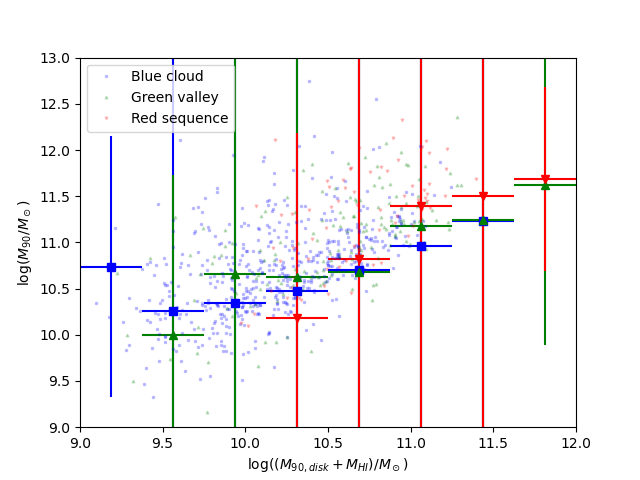

In [47]:
plt.figure()

plt.plot(BC_HI['M90_vis'], BC_HI['M90_map'], 
         'bs', markersize=2, alpha=0.2, label='Blue cloud')
plt.plot(GV_HI['M90_vis'], GV_HI['M90_map'], 
         'g^', markersize=2, alpha=0.2, label='Green valley')
plt.plot(RS_HI['M90_vis'], RS_HI['M90_map'], 
         'rv', markersize=2, alpha=0.2, label='Red sequence')

plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, BC_Mvis_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=BC_Mvis_errs, 
             c='b', fmt='s')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, GV_Mvis_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=GV_Mvis_errs, 
             c='g', fmt='^')
plt.errorbar(Mdisk_bins + 0.5*Mdisk_bin_width, RS_Mvis_medians, 
             xerr=0.5*Mdisk_bin_width, yerr=RS_Mvis_errs, 
             c='r', fmt='v')

plt.xlabel('log(($M_{90, disk} + M_{HI})/M_\odot$)')
plt.ylabel('log($M_{90}/M_\odot$)')

plt.xlim([9,12])
plt.ylim([9,13])

plt.legend();

# Distribution in mass ratios

In [30]:
def hist_norm(data, bins):
    '''
    Return the values to plot a normalized histogram.
    
    
    PARAMETERS
    ==========
    
    data : column of astropy table
        Data to be binned
        
    bins : ndarray of shape (n,)
        Bin edges
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,)
        Number of objects in each bin, normalized by the total number of 
        objects in the sample
        
    binned_data_err : ndarray of shape (n,)
        Statistical uncertainty in the count in each bin.
    '''
    
    # Bin data
    counts,_ = np.histogram(data, bins=bins)
    
    # Normalize binned data
    binned_data = counts/len(data)
    
    # Calculate uncertainty in each bin
    binned_data_err = np.sqrt(counts)/len(data)
    
    return binned_data, binned_data_err

In [31]:
mass_bins = np.linspace(0,25,101)
mass_bin_width = mass_bins[1] - mass_bins[0]

BC_M90Mdisk_binned, BC_M90Mdisk_err = hist_norm(BC['M90_Mdisk_ratio'], bins=mass_bins)
GV_M90Mdisk_binned, GV_M90Mdisk_err = hist_norm(GV['M90_Mdisk_ratio'], bins=mass_bins)
RS_M90Mdisk_binned, RS_M90Mdisk_err = hist_norm(RS['M90_Mdisk_ratio'], bins=mass_bins)

### $M_{90}/M_{90, \text{disk}}$

<IPython.core.display.Javascript object>


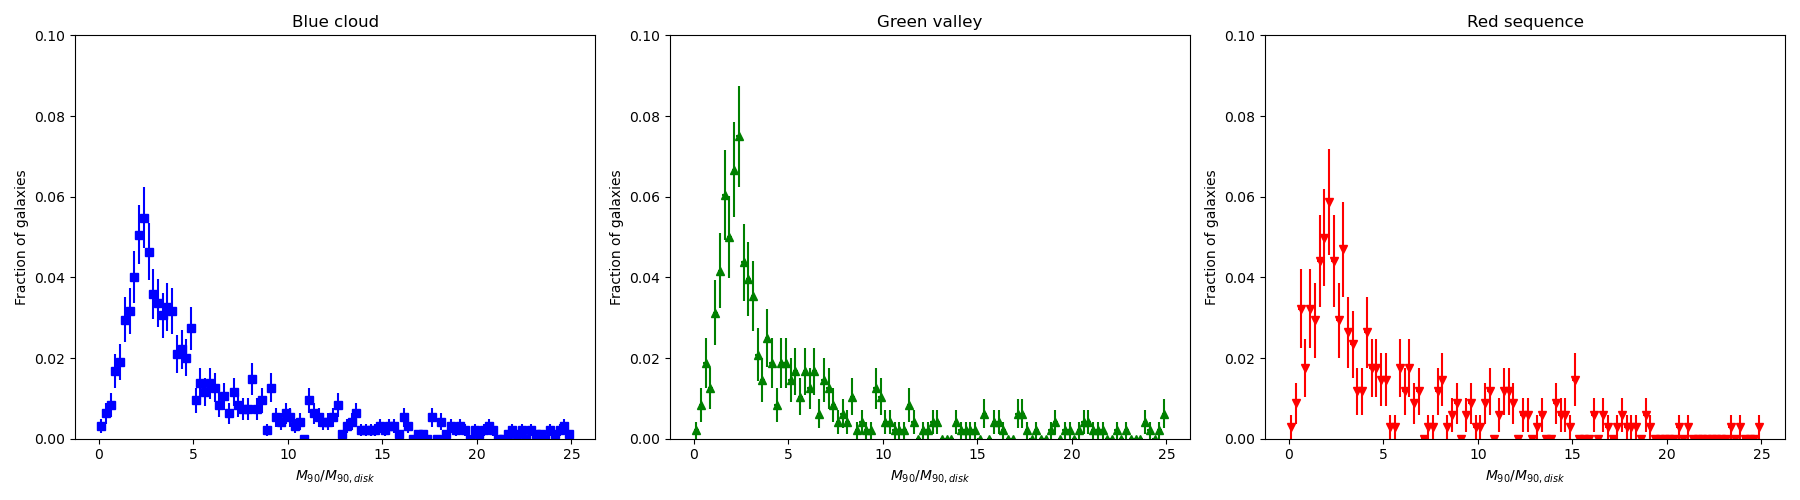

In [36]:
plt.figure(figsize=(18,5))

y_max = 0.1

################################################################################
# Blue cloud
#-------------------------------------------------------------------------------
plt.subplot(131)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, BC_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=BC_M90Mdisk_err, fmt='bs')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Blue cloud')
################################################################################


################################################################################
# Green valley
#-------------------------------------------------------------------------------
plt.subplot(132)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, GV_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=GV_M90Mdisk_err, fmt='g^')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Green valley')
################################################################################


################################################################################
# Red sequence
#-------------------------------------------------------------------------------
plt.subplot(133)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, RS_M90Mdisk_binned, 
             xerr=0.5*mass_bin_width, yerr=RS_M90Mdisk_err, fmt='rv')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/M_{90, disk}$')
plt.ylabel('Fraction of galaxies')

plt.title('Red sequence')
################################################################################

plt.tight_layout();

### $M_{90}/(M_{90, \text{disk}} + M_\text{HI})$

In [37]:
BC_M90Mvis_binned, BC_M90Mvis_err = hist_norm(BC_HI['M90_MdiskHI_ratio'], bins=mass_bins)
GV_M90Mvis_binned, GV_M90Mvis_err = hist_norm(GV_HI['M90_MdiskHI_ratio'], bins=mass_bins)
RS_M90Mvis_binned, RS_M90Mvis_err = hist_norm(RS_HI['M90_MdiskHI_ratio'], bins=mass_bins)

<IPython.core.display.Javascript object>


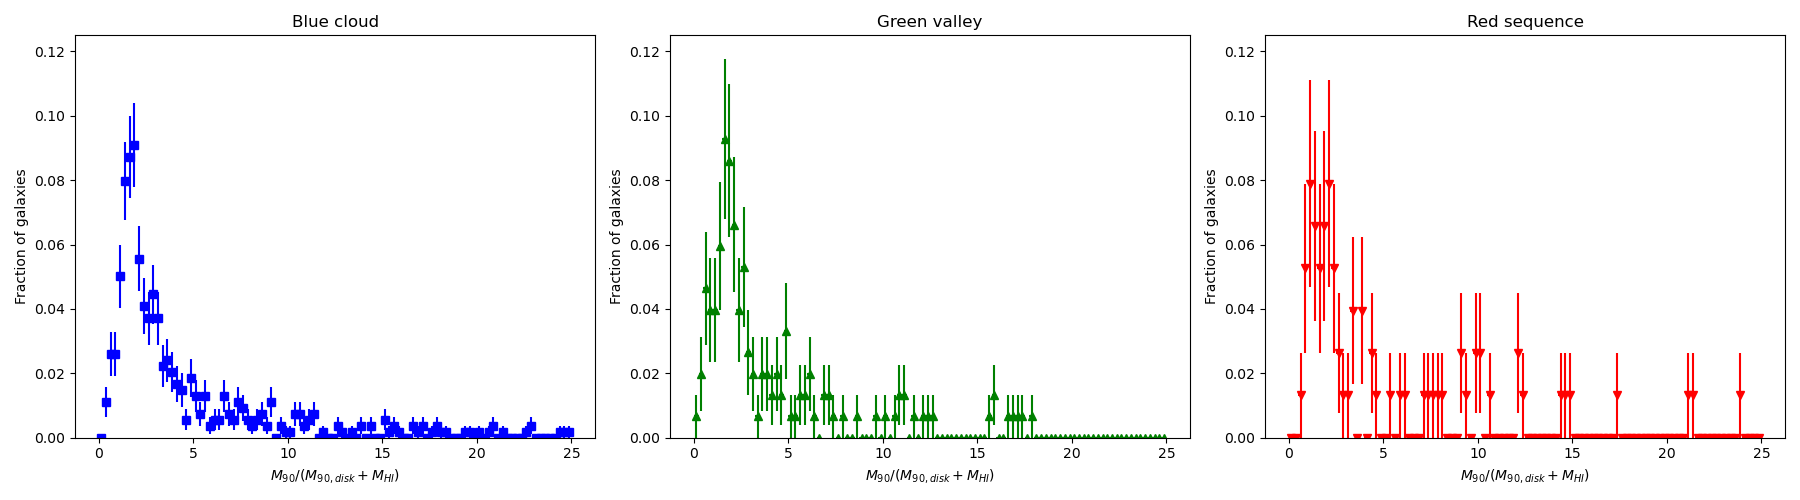

In [40]:
plt.figure(figsize=(18,5))

y_max = 0.125

################################################################################
# Blue cloud
#-------------------------------------------------------------------------------
plt.subplot(131)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, BC_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=BC_M90Mvis_err, fmt='bs')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Blue cloud')
################################################################################


################################################################################
# Green valley
#-------------------------------------------------------------------------------
plt.subplot(132)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, GV_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=GV_M90Mvis_err, fmt='g^')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Green valley')
################################################################################


################################################################################
# Red sequence
#-------------------------------------------------------------------------------
plt.subplot(133)

plt.errorbar(mass_bins[:-1] + 0.5*mass_bin_width, RS_M90Mvis_binned, 
             xerr=0.5*mass_bin_width, yerr=RS_M90Mvis_err, fmt='rv')

plt.ylim(0,y_max)

plt.xlabel('$M_{90}/(M_{90, disk} + M_{HI})$')
plt.ylabel('Fraction of galaxies')

plt.title('Red sequence')
################################################################################

plt.tight_layout();

# Relationship between $M_r$ and the mass ratios

In [48]:
Mr_bins = np.linspace(-22.5, -17.5, 13)
Mr_bin_width = Mr_bins[1] - Mr_bins[0]

Mdisk_medians, Mdisk_errs = bin_median(good_galaxies, 'rabsmag', Mr_bins, 'M90_Mdisk_ratio')
MdiskHI_medians, MdiskHI_errs = bin_median(goodHI_galaxies, 'rabsmag', Mr_bins, 'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<IPython.core.display.Javascript object>


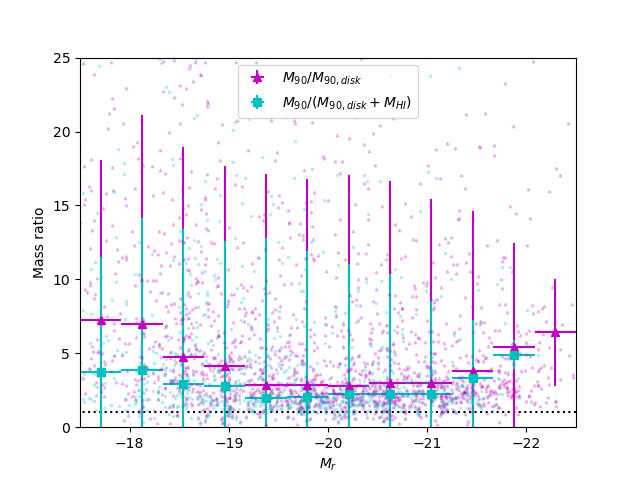

In [49]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.hlines(1, -22.5, -17.5, colors='k', linestyle=':')

plt.plot(good_galaxies['rabsmag'], good_galaxies['M90_Mdisk_ratio'], 
         'm^', markersize=2, alpha=0.2)
plt.plot(goodHI_galaxies['rabsmag'], goodHI_galaxies['M90_MdiskHI_ratio'], 
         'cs', markersize=2, alpha=0.2)

plt.errorbar(Mr_bins + 0.5*Mr_bin_width, Mdisk_medians, 
             xerr=0.5*Mr_bin_width, yerr=Mdisk_errs, 
             c='m', fmt='^', label='$M_{90}/M_{90, disk}$')
plt.errorbar(Mr_bins + 0.5*Mr_bin_width, MdiskHI_medians, 
             xerr=0.5*Mr_bin_width, yerr=MdiskHI_errs, 
             c='c', fmt='s', label='$M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlabel('$M_r$')
plt.ylabel('Mass ratio')

plt.xlim([-17.5,-22.5])
plt.ylim([0,25])

plt.legend();
################################################################################

# Relationship between metallicity and mass ratios

In [50]:
Z_bins = np.linspace(8.5, 10.5, 13)
Z_bin_width = Z_bins[1] - Z_bins[0]

ZMdisk_medians, ZMdisk_errs = bin_median(good_galaxies, 'Z12logOH', Z_bins, 'M90_Mdisk_ratio')
ZMdiskHI_medians, ZMdiskHI_errs = bin_median(goodHI_galaxies, 'Z12logOH', Z_bins, 'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


<IPython.core.display.Javascript object>


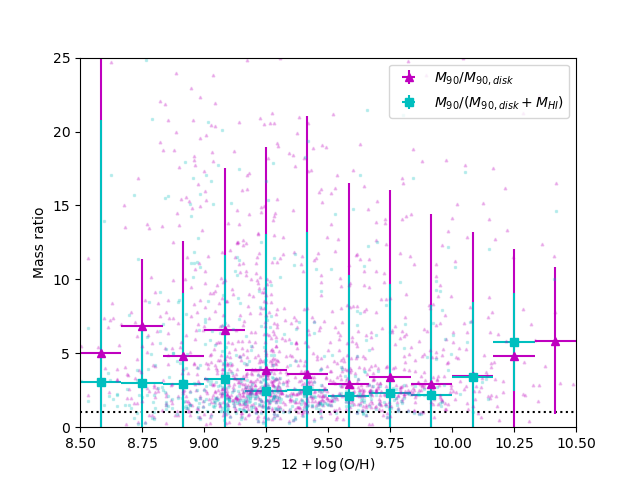

In [51]:
plt.figure()

################################################################################
# Stellar mass from stellar density map
#-------------------------------------------------------------------------------
plt.hlines(1, 8.5, 10.5, colors='k', linestyle=':')

plt.plot(good_galaxies['Z12logOH'], good_galaxies['M90_Mdisk_ratio'], 
         'm^', markersize=2, alpha=0.2)
plt.plot(goodHI_galaxies['Z12logOH'], goodHI_galaxies['M90_MdiskHI_ratio'], 
         'cs', markersize=2, alpha=0.2)

plt.errorbar(Z_bins + 0.5*Z_bin_width, ZMdisk_medians, 
             xerr=0.5*Z_bin_width, yerr=ZMdisk_errs, 
             c='m', fmt='^', label='$M_{90}/M_{90, disk}$')
plt.errorbar(Z_bins + 0.5*Z_bin_width, ZMdiskHI_medians, 
             xerr=0.5*Z_bin_width, yerr=ZMdiskHI_errs, 
             c='c', fmt='s', label='$M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlabel('$12 + \log$(O/H)')
plt.ylabel('Mass ratio')

plt.xlim([8.5,10.5])
plt.ylim([0,25])

plt.legend();
################################################################################

# Relationship between $M_r$, metallicity, and mass ratio

In [52]:
def bin2D_median(data, bin1_quantity, bin2_quantity, bins1, bins2, median_quantity):
    '''
    Calculate the median value of the quantity median_quantity when the objects in 
    data are binned by bin_quanitity1 and bin_quantity2.
    
    
    PARAMETERS
    ==========
    
    data : astropy table
        Galaxy data
        
    bin1_quantity, bin2_quantity : string
        Name of columns in data by which to bin the data
        
    bins1, bins2 : ndarray of shape (n,)
        Arrays of bin edges (arrays do not need to be the same length)
        
    median_quantity : string
        Name of column in data for which to calculate the median once the data is 
        binned
        
        
    RETURNS
    =======
    
    binned_data : ndarray of shape (n,m)
        Median values of median_quantity for each bin of bin1_quantity and bin2_quantity
    '''
    
    if bin1_quantity in ['Mstar', 'NSA_Mstar']:
        bin1_indices = np.digitize(np.log10(data[bin1_quantity]), bins1)
    else:
        bin1_indices = np.digitize(data[bin1_quantity], bins1)
    
    if bin2_quantity in ['Mstar', 'NSA_Mstar']:
        bin2_indices = np.digitize(np.log10(data[bin2_quantity]), bins2)
    else:
        bin2_indices = np.digitize(data[bin2_quantity], bins2)
    
    n1_bins = len(bins1)
    n2_bins = len(bins2)
    
    binned_median = np.zeros((n1_bins, n2_bins))
    
    for i in range(n1_bins):
        for j in range(n2_bins):
            # Find galaxies in this bin
            gal_in_bin = np.logical_and(bin1_indices == i, bin2_indices == j)

            # Calculate median of galaxies in bin
            if median_quantity in ['Mstar', 'NSA_Mstar', 'Mtot']:
                binned_median[i,j] = np.log10(np.median(data[median_quantity][gal_in_bin]))
            else:
                binned_median[i,j] = np.median(data[median_quantity][gal_in_bin])
        
    return binned_median

In [53]:
Mr_bins2d = np.linspace(-22.5, -17.5, 5)
Z_bins2d = np.linspace(8.5, 10.5, 5)

M90Mdisk_median = bin2D_median(good_galaxies, 
                               'rabsmag', 'Z12logOH', 
                               Mr_bins2d, Z_bins2d, 
                               'M90_Mdisk_ratio')

M90MHI_median = bin2D_median(goodHI_galaxies, 
                             'rabsmag', 'Z12logOH', 
                             Mr_bins2d, Z_bins2d, 
                             'M90_MdiskHI_ratio')

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3417: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


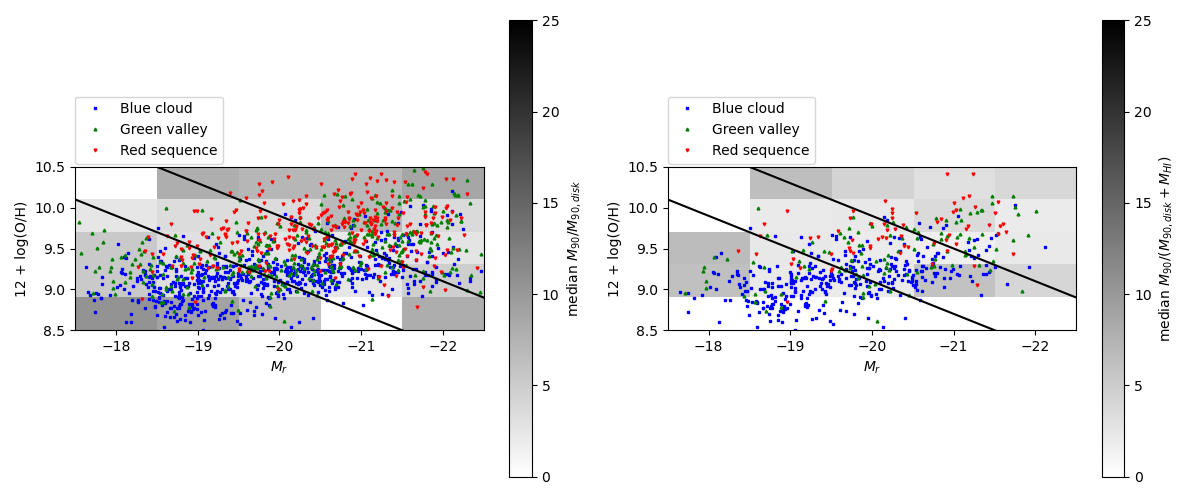

In [54]:
plt.figure(figsize=(12,5))

################################################################################
# Mtot/M* with MaNGA stellar mass
#-------------------------------------------------------------------------------
plt.subplot(121)

plt.imshow(M90Mdisk_median, cmap='gray_r', vmin=0, vmax=25,
           extent=(Mr_bins2d[0], Mr_bins2d[-1], Z_bins2d[-1], Z_bins2d[0]))

plt.plot(BC['rabsmag'], BC['Z12logOH'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV['rabsmag'], GV['Z12logOH'], 'g^', markersize=2, label='Green valley')
plt.plot(RS['rabsmag'], RS['Z12logOH'], 'rv', markersize=2, label='Red sequence')

Mr = np.linspace(-23,-17,5)
plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')

plt.xlabel('$M_r$')
plt.ylabel('12 + log(O/H)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/M_{90, disk}$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(Z_bins2d[0], Z_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################


################################################################################
# Mtot/(M* + MHI) with MaNGA stellar mass
#-------------------------------------------------------------------------------
plt.subplot(122)

plt.imshow(M90MHI_median, cmap='gray_r', vmin=0, vmax=25,
           extent=(Mr_bins2d[0], Mr_bins2d[-1], Z_bins2d[-1], Z_bins2d[0]))

plt.plot(BC_HI['rabsmag'], BC_HI['Z12logOH'], 'bs', markersize=2, label='Blue cloud')
plt.plot(GV_HI['rabsmag'], GV_HI['Z12logOH'], 'g^', markersize=2, label='Green valley')
plt.plot(RS_HI['rabsmag'], RS_HI['Z12logOH'], 'rv', markersize=2, label='Red sequence')

plt.plot(Mr, 0.4*Mr + 17.9, 'k')
plt.plot(Mr, 0.4*Mr + 17.1, 'k')

plt.xlabel('$M_r$')
plt.ylabel('12 + log(O/H)')

cbar = plt.colorbar()
cbar.ax.set_ylabel('median $M_{90}/(M_{90, disk} + M_{HI})$')

plt.xlim(Mr_bins2d[-1], Mr_bins2d[0])
plt.ylim(Z_bins2d[0], Z_bins2d[-1])

plt.legend(bbox_to_anchor=(0,1.02,1,0.102), loc='lower left', ncol=1, borderaxespad=0)
################################################################################

plt.tight_layout();

In [55]:
good_galaxies

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,Hubble_type,Tidal,GZ_edge_on,GZ_bar,GZ_spiral,mangaid,DL_ttype,DL_s0,DL_edge_on,DL_bar_GZ2,DL_bar_N10,DL_merge,R90_kpc,V90_kms,M90_Mdisk_ratio
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str6,int64,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64
8466,3704,1365,395,53062,271835,169.51344705905626,45.11302884764515,0.7605966925621033,38.829132080078125,0.10723754018545151,197521702912.0,-9.0,556.3518364096462,13.118034688446018,24.86932770334229,2.3940713635654394,30.91707350025701,711.2244069248968,1.504693687838659,5.4916272484783235,0.13302098092829132,57.779777593071636,719.3795558341147,138.28434946354537,2.3152653148416644,0.34190799281498013,679.599992107137,0.19382250308990479,0.00374262968525048,1009538499616.6031,47607149629.30096,675644982315.1558,47607149629.30096,333893517301.4474,2.023534292536643,0.14258183271740504,-22.550582885742188,5.7748020245614216,0.5573857339405546,4.4524855677404895,0.01905772437112725,13.420360045586433,3.15075413321062,-99.0,-99.0,1.0,0,2,7.729268375064253,14.444944398267909,169.89999802678426,1238769,-99.0,2.2696952521800995,0.3984819734345351,14.027650044796358,3.023534292536643,0.14258183271740504,2.000058917217074,781.0113415220086,852.3600886325648,-31.43738195467922,0.9191594634941147,0.9996160361859993,14.92701049920957,1.9016935015289356,90.83466065793536,6.646944003882518,25.925575994142413,0.3809794467255559,18.674050361874897,0.6673493853020757,583.2328253935871,34.152175648873666,2.4839515490849142,0.31532918333860444,3.6599846826451374,0.8402844742808679,12.220250755739624,11.288857167962382,2643.9946172860446,143.58157468583985,3.0807158316405787,0.11520078007864021,11.167253620298242,13.076544983597937,1.2732320010865508,13.470475196838379,53.76509128464788,12836786.035053207,nan,nan,nan,2,-2.0,Sa,1,0.09673986649898424,0.0360929634786334,0.0,1-256832,-2.5520172119140625,0.2188923954963684,0.022004038095474243,0.48675888776779175,0.02322487160563469,0.5364497900009155,20.995456918513632,580.1967832784323,11.297884626878306
8465,1901,1281,231,52753,247928,197.44581468983537,48.899591403437014,0.76849281787872